# 지도학습-로지스틱-선형계열 SHAP

In [4]:
from hossam import *

# 파이썬 기본 라이브러리
from pandas import DataFrame, concat, get_dummies
import numpy as np
from itertools import combinations

# 시각화 라이브러리
from matplotlib import pyplot as plt
import seaborn as sb

# 통계 라이브러리
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset, het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from pingouin import anova, welch_anova
from scipy.stats import (
    normaltest,
    bartlett,
    levene,
    ttest_ind,
    pearsonr,
    spearmanr,
    shapiro,
    jarque_bera,
    t,
    f,
)

# 머신러닝 라이브러리
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.impute import SimpleImputer

# 학습모델
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    SGDRegressor
)

# 확률적 경사 하강법
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

# SVR
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance

# 로지스틱 회귀 모형
from sklearn.linear_model import LogisticRegression

# 로지스틱 성능평가 함수
from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, 
                            precision_score, f1_score, precision_recall_curve, log_loss)

# 군집 시각화 참조
from scipy.spatial import ConvexHull

# 확률 밀도 함수
import shap

## 1. 준비작업
### 1. 데이터 가져오기

In [2]:
origin = load_data('pima_indians_diabetes_preprocessed')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

df = origin.copy()

# 종속변수 -> 정수형으로 변환
df['Outcome'] = df['Outcome'].astype('int')
yname = 'Outcome'
x = df.drop(columns = [yname])
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.2, random_state = 52
)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

캐글에서 제공하는 pima_indians_diabetes의 전처리 완료 버전(결측치 정제+로그변환) (출처: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)
데이터셋 크기: (768, 9)
열 개수: 9
행 개수: 768
<class 'pandas.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 54.1 KB
None


((614, 8), (154, 8), (614,), (154,))

## 2. 로지스틱 모형 적합

In [3]:
%%time

pipe = Pipeline([('VIF_Selector', VIFSelector()), ('scaler', StandardScaler()), ('model', LogisticRegression(random_state = 52))])

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs'],
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__max_iter': [100, 300, 500],
    'model__class_weight': [None, 'balanced']
    
    # poly 커널 확장용 (필요시 사용, 학습속도가 매우 느려짐)
    # 'model__kernel':['poly'],
    # 'model__degree':[2, 3, 4],
    # 'model__coef0':[0.0, 0.5, 1.0]
    }

# 그리드 서치 객체 생성
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, cv=5, scoring ='roc_auc', n_jobs = -1)

gs.fit(x_train, y_train)
estimator = gs.best_estimator_
estimator

CPU times: total: 531 ms
Wall time: 21 s


Pipeline(steps=[('VIF_Selector', VIFSelector()), ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=1, class_weight='balanced',
                                    random_state=52))])

## 3. SHAP 분석
### 1. SHAP 객체 생성
- shap의 LinearExplainer는 Tree계열과 다르게, 변환이 완료된 훈련데이터를 요구

In [5]:
# pipeline에서 단독 학습 모델 객체 추출
model = estimator.named_steps['model']

# 훈련 데이터에 대한 VIF 선택기와 스케일러 변환 적용
x_vif = estimator.named_steps['VIF_Selector'].transform(x_train)
x_scaled = estimator.named_steps['scaler'].transform(x_vif)

# 훈련 데이터의 스케일된 특정 행렬을 사용하여 SHAP 마스커 생성
masker = shap.maskers.Independent(x_scaled)

# 선형 설명자 생성
explainer = shap.LinearExplainer(model, masker = masker)

# SHAP 값 계산: shape = [n_samples, n_features]
shap_values = explainer.shap_values(x_scaled)
shap_values

array([[ 0.36637001,  1.19352029, -0.02374752, ...,  0.13558711,
         0.0109997 ,  0.3214378 ],
       [ 0.49955471, -0.66502013,  0.00984162, ...,  1.34818579,
        -0.39504107,  0.25401179],
       [ 0.36637001,  0.19161826, -0.01702969, ..., -0.27607911,
         0.26673056,  0.46305622],
       ...,
       [ 0.0942495 , -0.19673964,  0.01991836, ..., -1.18774282,
        -0.0015263 ,  0.13042584],
       [-0.00905658, -1.44309066,  0.03671293, ..., -1.20308754,
         0.01213369, -0.41599405],
       [ 0.25002199, -0.8945048 ,  0.04343076, ...,  0.2996527 ,
        -0.00381409,  0.2769961 ]])

### 2. SHAP 분석 결과 도출

In [ ]:
# DataFrame 변환
shap_df = DataFrame(
    shap_values,
    columns = x_vif.columns,
    index = x_vif.index
)

# 요약 통계
summary_df = DataFrame({
    'feature': shap_df.columns,
    'mean_abs_shap': shap_df.abs().mean().values,
    'mean_shap': shap_df.mean().values,
    'std_shap': shap_df.std().values
    }
)

# 영향 방향 (보수적 표현)
summary_df['direction'] = np.where(
    summary_df['mean_shap'] > 0,
    '양(+) 경향',
    np.where(summary_df['mean_shap'] < 0, '음(-) 경향','혼합/미약')
)

# 변동성 지표
summary_df['cv'] = summary_df['std_shap'] / (summary_df['mean_abs_shap'] + 1e-9)

summary_df['variability'] = np.where(
    summary_df['cv'] < 1,
    'stable',                          # 변동성 낮음 - 평균 대비 일관적 영향 의미
    'variable'                         # 변동성 큼 - 상황 의존적 영향 의미
)

# 중요도 기준 정렬
summary_df = summary_df.sort_values('mean_abs_shap', ascending = False).reset_index(
    drop = True
)

# 8. 중요 변수 표시 (누적 80%)
total_importance = summary_df['mean_abs_shap'].sum()
summary_df['importance_ratio'] = summary_df['mean_abs_shap'] / total_importance
summary_df['importance_cumsum'] = summary_df['importance_ratio'].cumsum()

summary_df['is_important'] = np.where(
    summary_df['importance_cumsum'] <= 0.80,
    'core',   # 누적 80% 내 중요 변수 - 모델 결정 요인 의미 명확
    'secondary' # 누적 80% 초과 변수 - 보조적/상황적 영향 요인 의미
)

summary_df

,feature,mean_abs_shap,mean_shap,std_shap,direction,cv,variability,importance_ratio,importance_cumsum,is_important
0,Glucose,0.918,-0.039,1.131,음(-) 경향,1.232,variable,0.388,0.388,core
1,BMI,0.572,0.053,0.708,양(+) 경향,1.236,variable,0.242,0.630,core
2,Pregnancies,0.301,-0.048,0.356,음(-) 경향,1.182,variable,0.127,0.757,core
3,Age,0.277,-0.027,0.318,음(-) 경향,1.150,variable,0.117,0.874,secondary
4,DiabetesPedigreeFunction,0.254,0.014,0.318,양(+) 경향,1.249,variable,0.108,0.982,secondary
5,BloodPressure,0.031,-0.005,0.040,음(-) 경향,1.298,variable,0.013,0.995,secondary
6,Insulin,0.009,-0.001,0.016,음(-) 경향,1.657,variable,0.004,0.999,secondary
7,SkinThickness,0.003,-0.000,0.004,음(-) 경향,1.409,variable,0.001,1.000,secondary


### 2. Summary plot
#### 1. 시각화를 위해 앞에서 추출한 후 데이터를 DataFrame으로 구성

In [7]:
x = DataFrame(x_scaled, columns = x_vif.columns, index = x_vif.index)
x

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
754,1.165,1.091,0.464,0.452,0.007,0.117,-0.010,1.096
558,1.540,-0.554,-0.373,1.144,0.007,1.832,-1.289,0.884
584,1.165,0.205,0.297,-0.432,3.161,-0.465,0.795,1.541
78,-1.696,0.429,-0.038,0.149,0.007,1.507,-0.668,-0.580
193,1.540,0.552,-0.038,0.149,0.007,2.435,0.451,0.734
...,...,...,...,...,...,...,...,...
503,1.012,-0.927,-0.707,-0.307,-0.910,0.249,0.948,0.810
86,1.740,-0.436,-0.038,2.080,0.007,0.705,-1.056,1.096
151,0.400,-0.139,-0.624,0.149,0.007,-1.754,-0.050,0.495
525,0.109,-1.242,-1.042,-1.306,0.007,-1.776,-0.007,-1.224


#### 2. SHAP 시각화

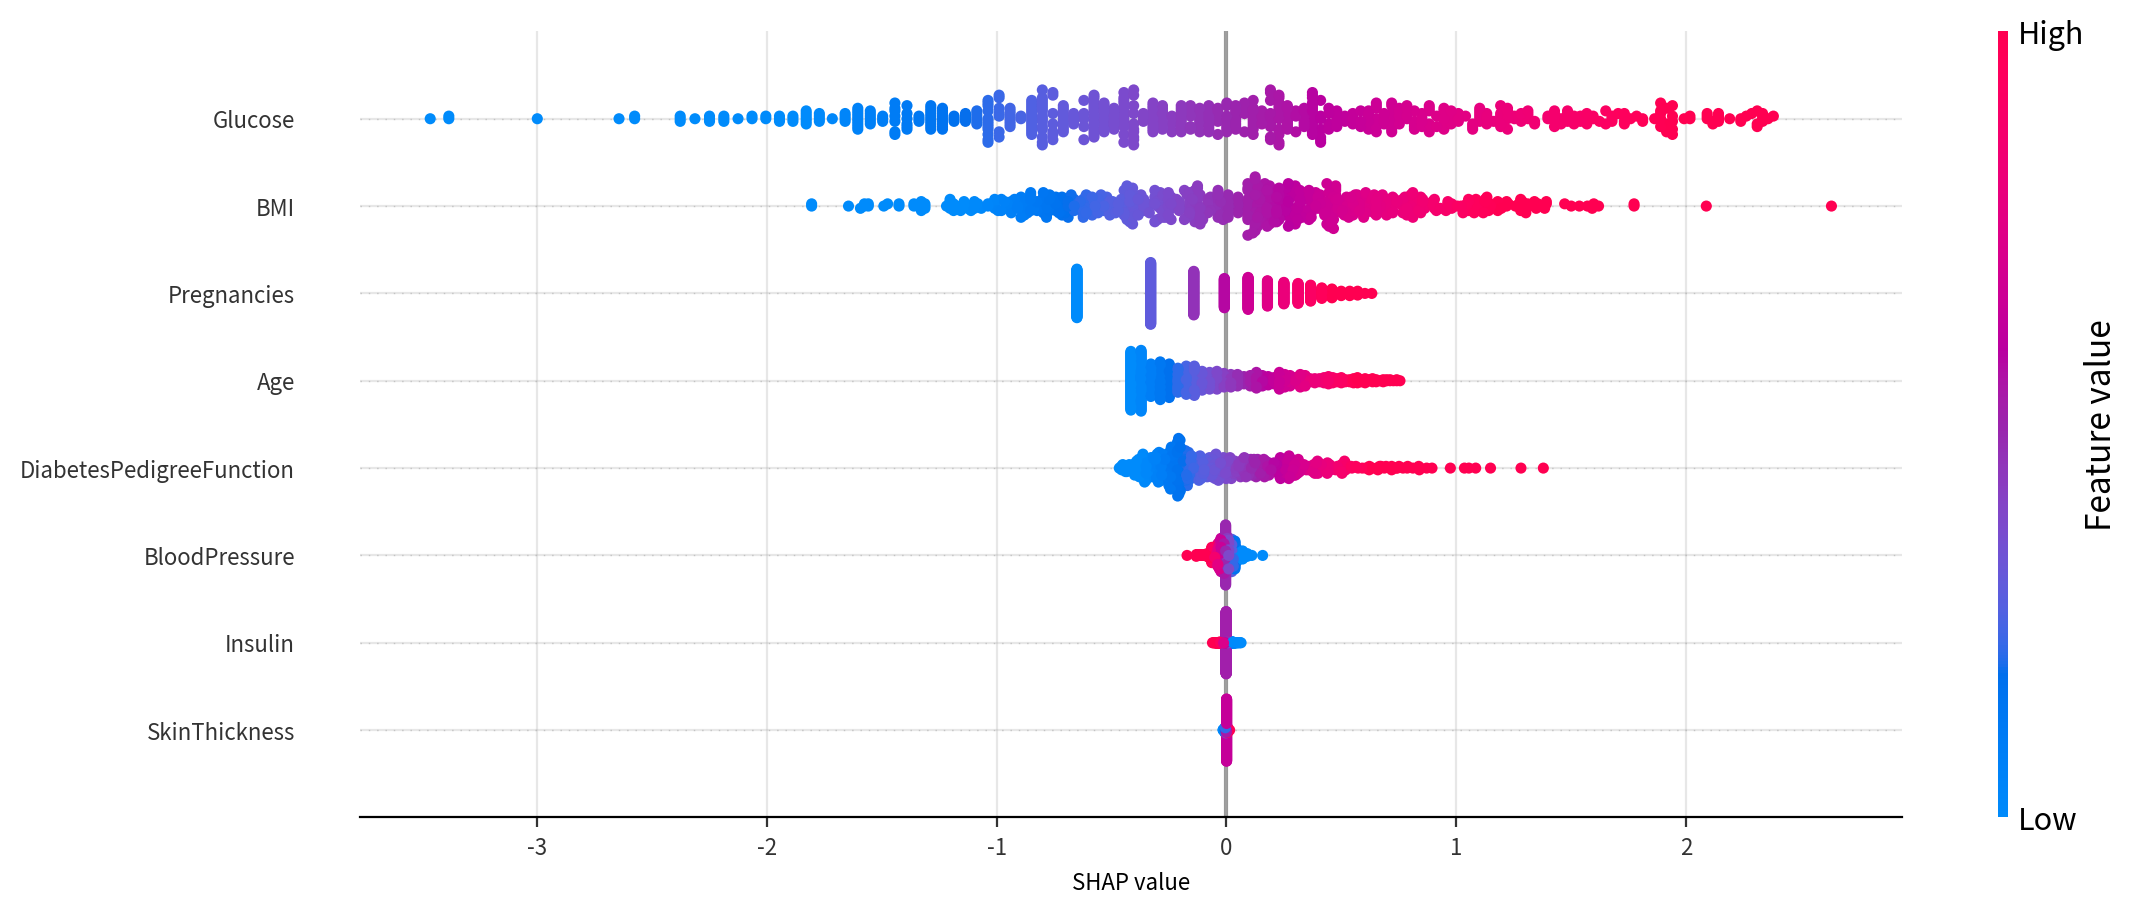

In [10]:
width = 1500
my_dpi = 200

shap.summary_plot(shap_values, x, show = False)

fig = plt.gcf()
fig.set_size_inches(width / 100, len(summary_df) * 60 /100)
fig.set_dpi(my_dpi)
ax = fig.get_axes()[0]

ax.grid(True, alpha = 0.3)

plt.xlabel('SHAP value', fontsize = 8)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

plt.show()
plt.close()

#### 인사이트
- 핵심 예측 인자 집중화
    - Glucose(0.388), BMI(0.242), Pregnancies(0.127)의 3개 피처가 전체 중요도의 75.7% 차지
    - 나머지 5개 피처는 모두 secondary 등급으로 개별 영향력 제한적
- 양극화된 피처 효과
    - 양(+)의 경향: BMI(+0.053), DiabetesPedigreeFunction(+0.014) -> 증가 시 양성 예측 확률 상승
    - 음(-)의 경향: Glucose(-0.039), Age(-0.027), Pregnancies(-0.048) -> 증가 시 양성 예측 확률 하강
- 높은 불안정성 지표
    - 모든 피처의 CV 값이 1.15~1.65 범위로 상당한 변동성 보유
    - Insulin(CV 1.657)과 SkinThickness(CV 1.409)에서 가장 높은 불안정성
    - 동일 피처 값이라도 샘플에 따라 SHAP 값의 변동폭이 크다는 의미
- 절댓값과 방향성의 불일치
    - Pregnancies: 절댓값(0.301)은 높으나 평균 SHAP(-0.048)은 절댓값 대비 작음 -> 피처 값에 따라 방향 변화 심함
    - Glucose: 절댓값(0.918) 대비 평균 SHAP(-0.039) 매우 작음 -> 개별 샘플마다 영향 방향 불일치

### 3. SHAP 분석 통합 함수

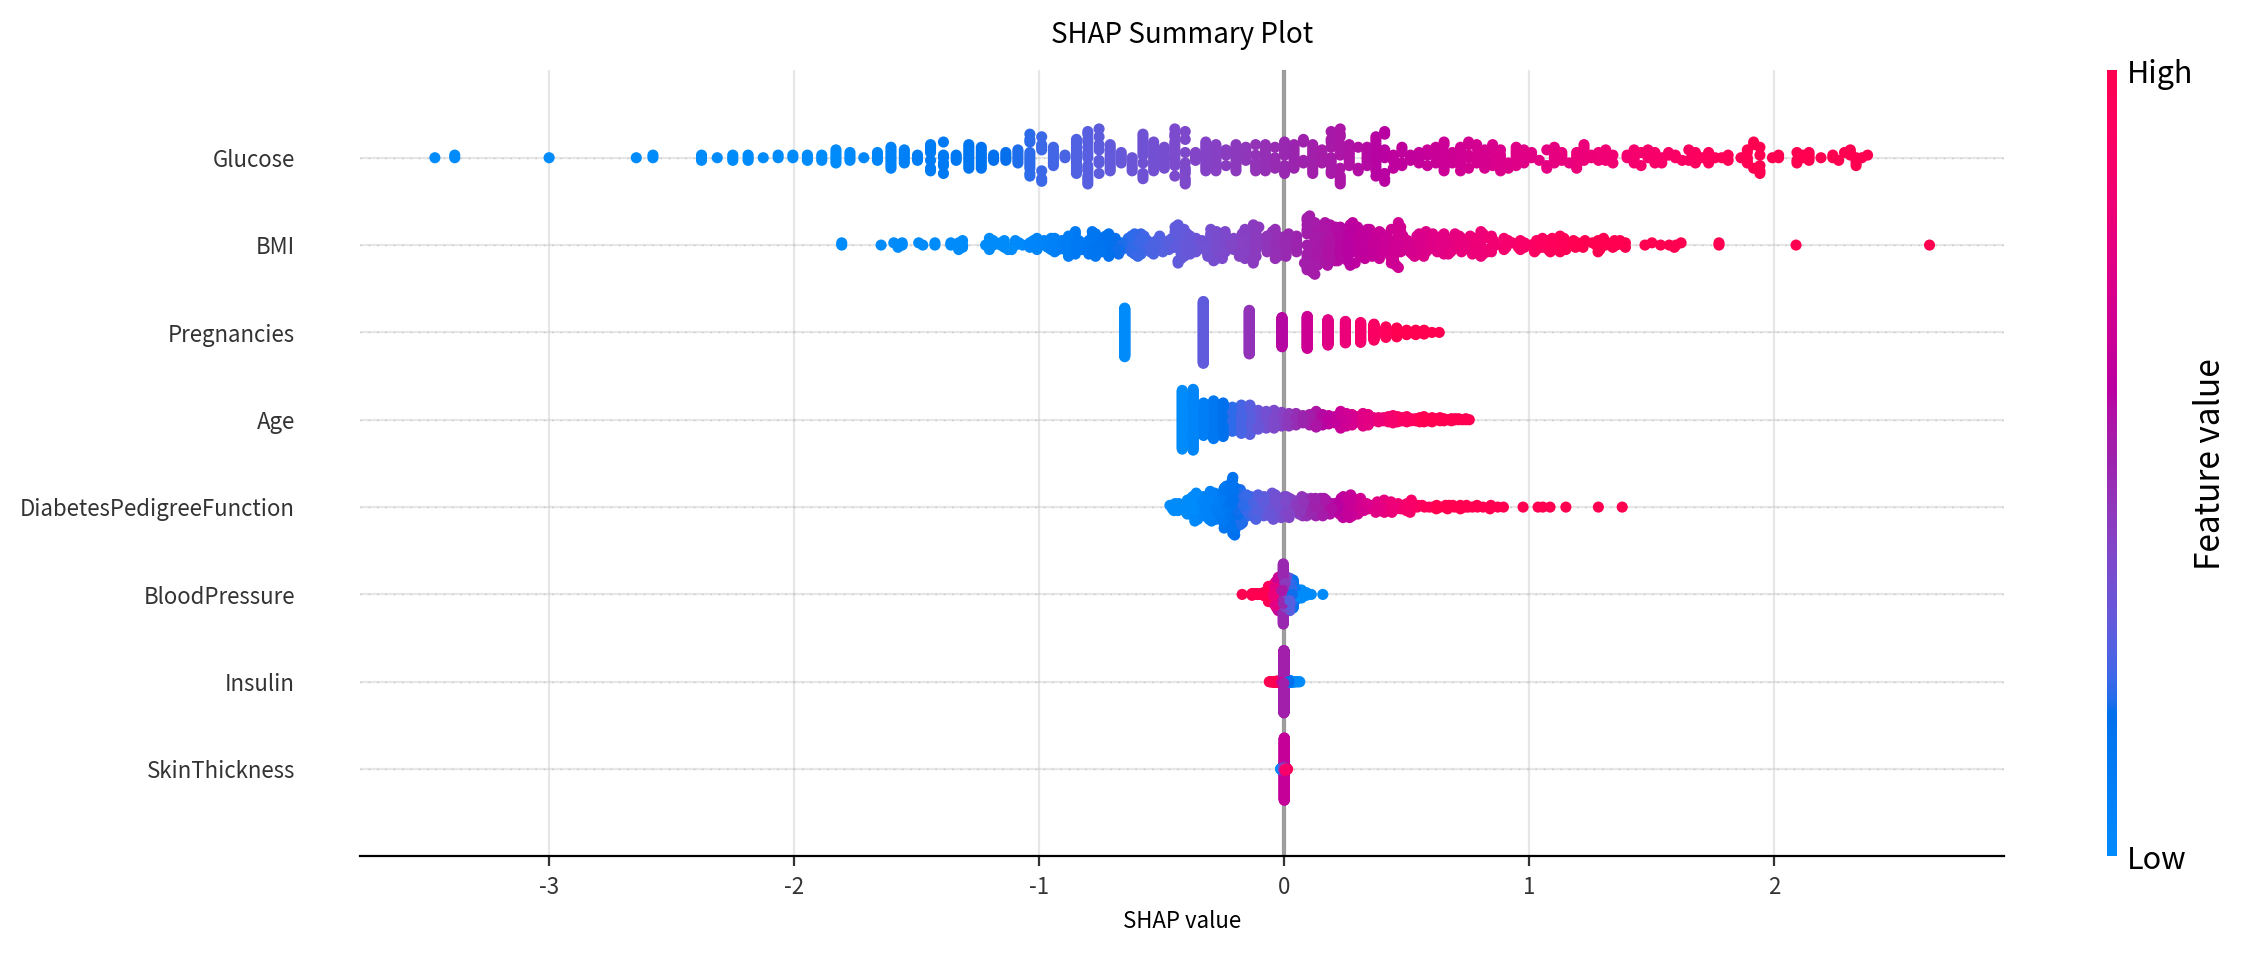

,feature,mean_abs_shap,mean_shap,std_shap,direction,cv,variability,importance_ratio,importance_cumsum,is_important
0,Glucose,0.918,-0.039,1.131,음(-) 경향,1.232,variable,0.388,0.388,core
1,BMI,0.572,0.053,0.708,양(+) 경향,1.236,variable,0.242,0.630,core
2,Pregnancies,0.301,-0.048,0.356,음(-) 경향,1.182,variable,0.127,0.757,core
3,Age,0.277,-0.027,0.318,음(-) 경향,1.150,variable,0.117,0.874,secondary
4,DiabetesPedigreeFunction,0.254,0.014,0.318,양(+) 경향,1.249,variable,0.108,0.982,secondary
5,BloodPressure,0.031,-0.005,0.040,음(-) 경향,1.298,variable,0.013,0.995,secondary
6,Insulin,0.009,-0.001,0.016,음(-) 경향,1.657,variable,0.004,0.999,secondary
7,SkinThickness,0.003,-0.000,0.004,음(-) 경향,1.409,variable,0.001,1.000,secondary


array([[ 3.66370005e-01,  1.19352029e+00, -2.37475226e-02,
         1.59167714e-03, -1.06402253e-03,  1.35587113e-01,
         1.09996996e-02,  3.21437797e-01],
       [ 4.99554705e-01, -6.65020126e-01,  9.84161828e-03,
         4.03414454e-03, -1.06402253e-03,  1.34818579e+00,
        -3.95041073e-01,  2.54011794e-01],
       [ 3.66370005e-01,  1.91618259e-01, -1.70296944e-02,
        -1.53230882e-03, -5.00752532e-02, -2.76079114e-01,
         2.66730565e-01,  4.63056225e-01],
       [-6.50852563e-01,  4.45402245e-01, -3.59403808e-03,
         5.19221708e-04, -1.06402253e-03,  1.11793270e+00,
        -1.98046170e-01, -2.11246035e-01],
       [ 4.99554705e-01,  5.84445304e-01, -3.59403808e-03,
         5.19221708e-04, -1.06402253e-03,  1.77434545e+00,
         1.57395283e-01,  2.06394534e-01]])

In [14]:
def hs_shap_analysis(
        model,
        x: DataFrame,
        plot: bool = True,
        width: int = 1600
):
    # 추가: SHAP 유형 판별
    # Pipeline 라인 객체와 그렇지 않은 경우 모두 처리
    if isinstance(model, Pipeline):
        estimator = model.named_steps['model']
        is_pipeline = True
    else:
        estimator = model
        is_pipeline = False

    # 선형계열 인지 아닌지 판별
    is_linear_model = isinstance(estimator, (LinearRegression, Ridge, Lasso, SGDRegressor, LogisticRegression))

    # 전달된 독립변수 복사
    x_df = x.copy()
    columns = x.columns.tolist()
    indexs = x.index.tolist()

    # 업뎃: SHAP 분석값 도출
    # SHAP Explainer
    if is_linear_model:
        # Pipeline인 경우 파이프라인의 마지막 step을 제외하고 순환하면서 데이터 변환 적용
        if is_pipeline:
            for name, step in list(model.named_steps.items()):
                if name == 'model':
                    continue
                
                x_df = step.transform(x_df)
        masker = shap.maskers.Independent(x_df)
        explainer = shap.LinearExplainer(estimator, masker = masker)
    else:
        explainer = shap.TreeExplainer(estimator)

    # SHAP 값 계산: shape = [n_samples, n_features]
    shap_values = explainer.shap_values(x_df)

    # DataFrame 변환
    shap_df = DataFrame(
        shap_values,
        columns = columns,
        index = indexs
    )

    # 요약 통계
    summary_df = DataFrame({
        'feature': shap_df.columns,
        'mean_abs_shap': shap_df.abs().mean().values,
        'mean_shap': shap_df.mean().values,
        'std_shap': shap_df.std().values
        }
    )

    # 영향 방향 (보수적 표현)
    summary_df['direction'] = np.where(
        summary_df['mean_shap'] > 0,
        '양(+) 경향',
        np.where(summary_df['mean_shap'] < 0, '음(-) 경향','혼합/미약')
    )

    # 변동성 지표
    summary_df['cv'] = summary_df['std_shap'] / (summary_df['mean_abs_shap'] + 1e-9)

    summary_df['variability'] = np.where(
        summary_df['cv'] < 1,
        'stable',                          # 변동성 낮음 - 평균 대비 일관적 영향 의미
        'variable'                         # 변동성 큼 - 상황 의존적 영향 의미
    )

    # 중요도 기준 정렬
    summary_df = summary_df.sort_values('mean_abs_shap', ascending = False).reset_index(
        drop = True
    )

    # 8. 중요 변수 표시 (누적 80%)
    total_importance = summary_df['mean_abs_shap'].sum()
    summary_df['importance_ratio'] = summary_df['mean_abs_shap'] / total_importance
    summary_df['importance_cumsum'] = summary_df['importance_ratio'].cumsum()

    summary_df['is_important'] = np.where(
        summary_df['importance_cumsum'] <= 0.80,
        'core',   # 누적 80% 내 중요 변수 - 모델 결정 요인 의미 명확
        'secondary' # 누적 80% 초과 변수 - 보조적/상황적 영향 요인 의미
    )

    # 시각화
    if plot:
        shap.summary_plot(shap_values, x_train, show = False)

        fig = plt.gcf()
        fig.set_size_inches(width / 100, len(summary_df) * 60 /100)
        fig.set_dpi(my_dpi)
        ax = fig.get_axes()[0]

        ax.grid(True, alpha = 0.3)
        ax.set_title('SHAP Summary Plot', fontsize = 10, pad = 10)
        plt.xlabel('SHAP value', fontsize = 8)
        plt.xticks(fontsize = 8)
        plt.yticks(fontsize = 8)

        plt.show()
        plt.close()
    
    return summary_df, shap_values

summary_df, shap_values = hs_shap_analysis(estimator, x_train)
display(summary_df)
display(shap_values[:5])

### 4. SHAP dependence 분석

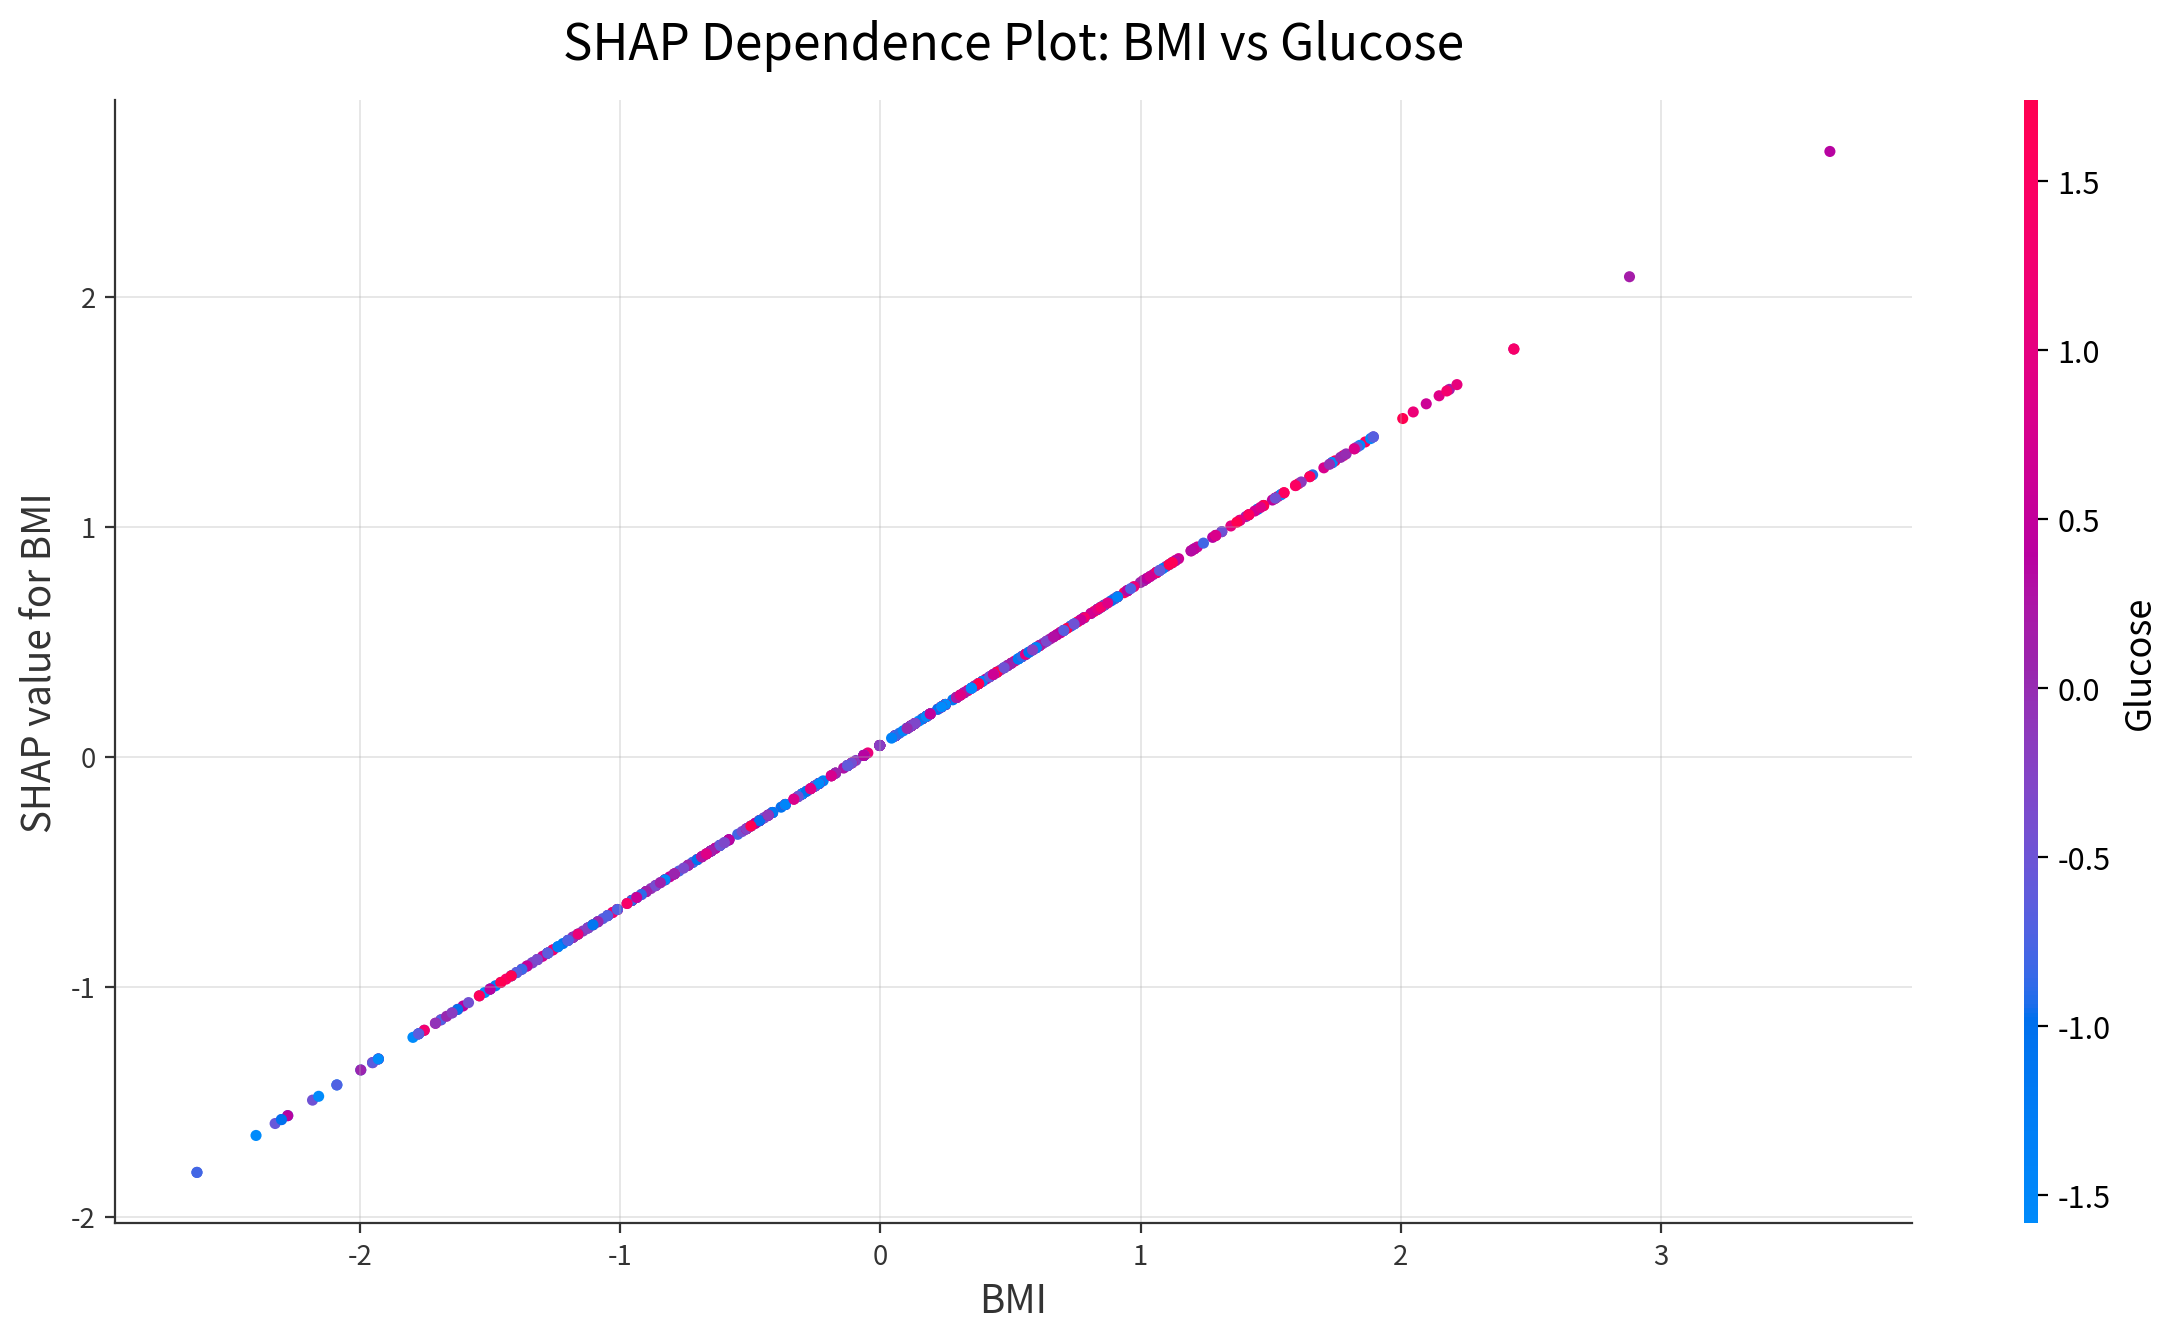

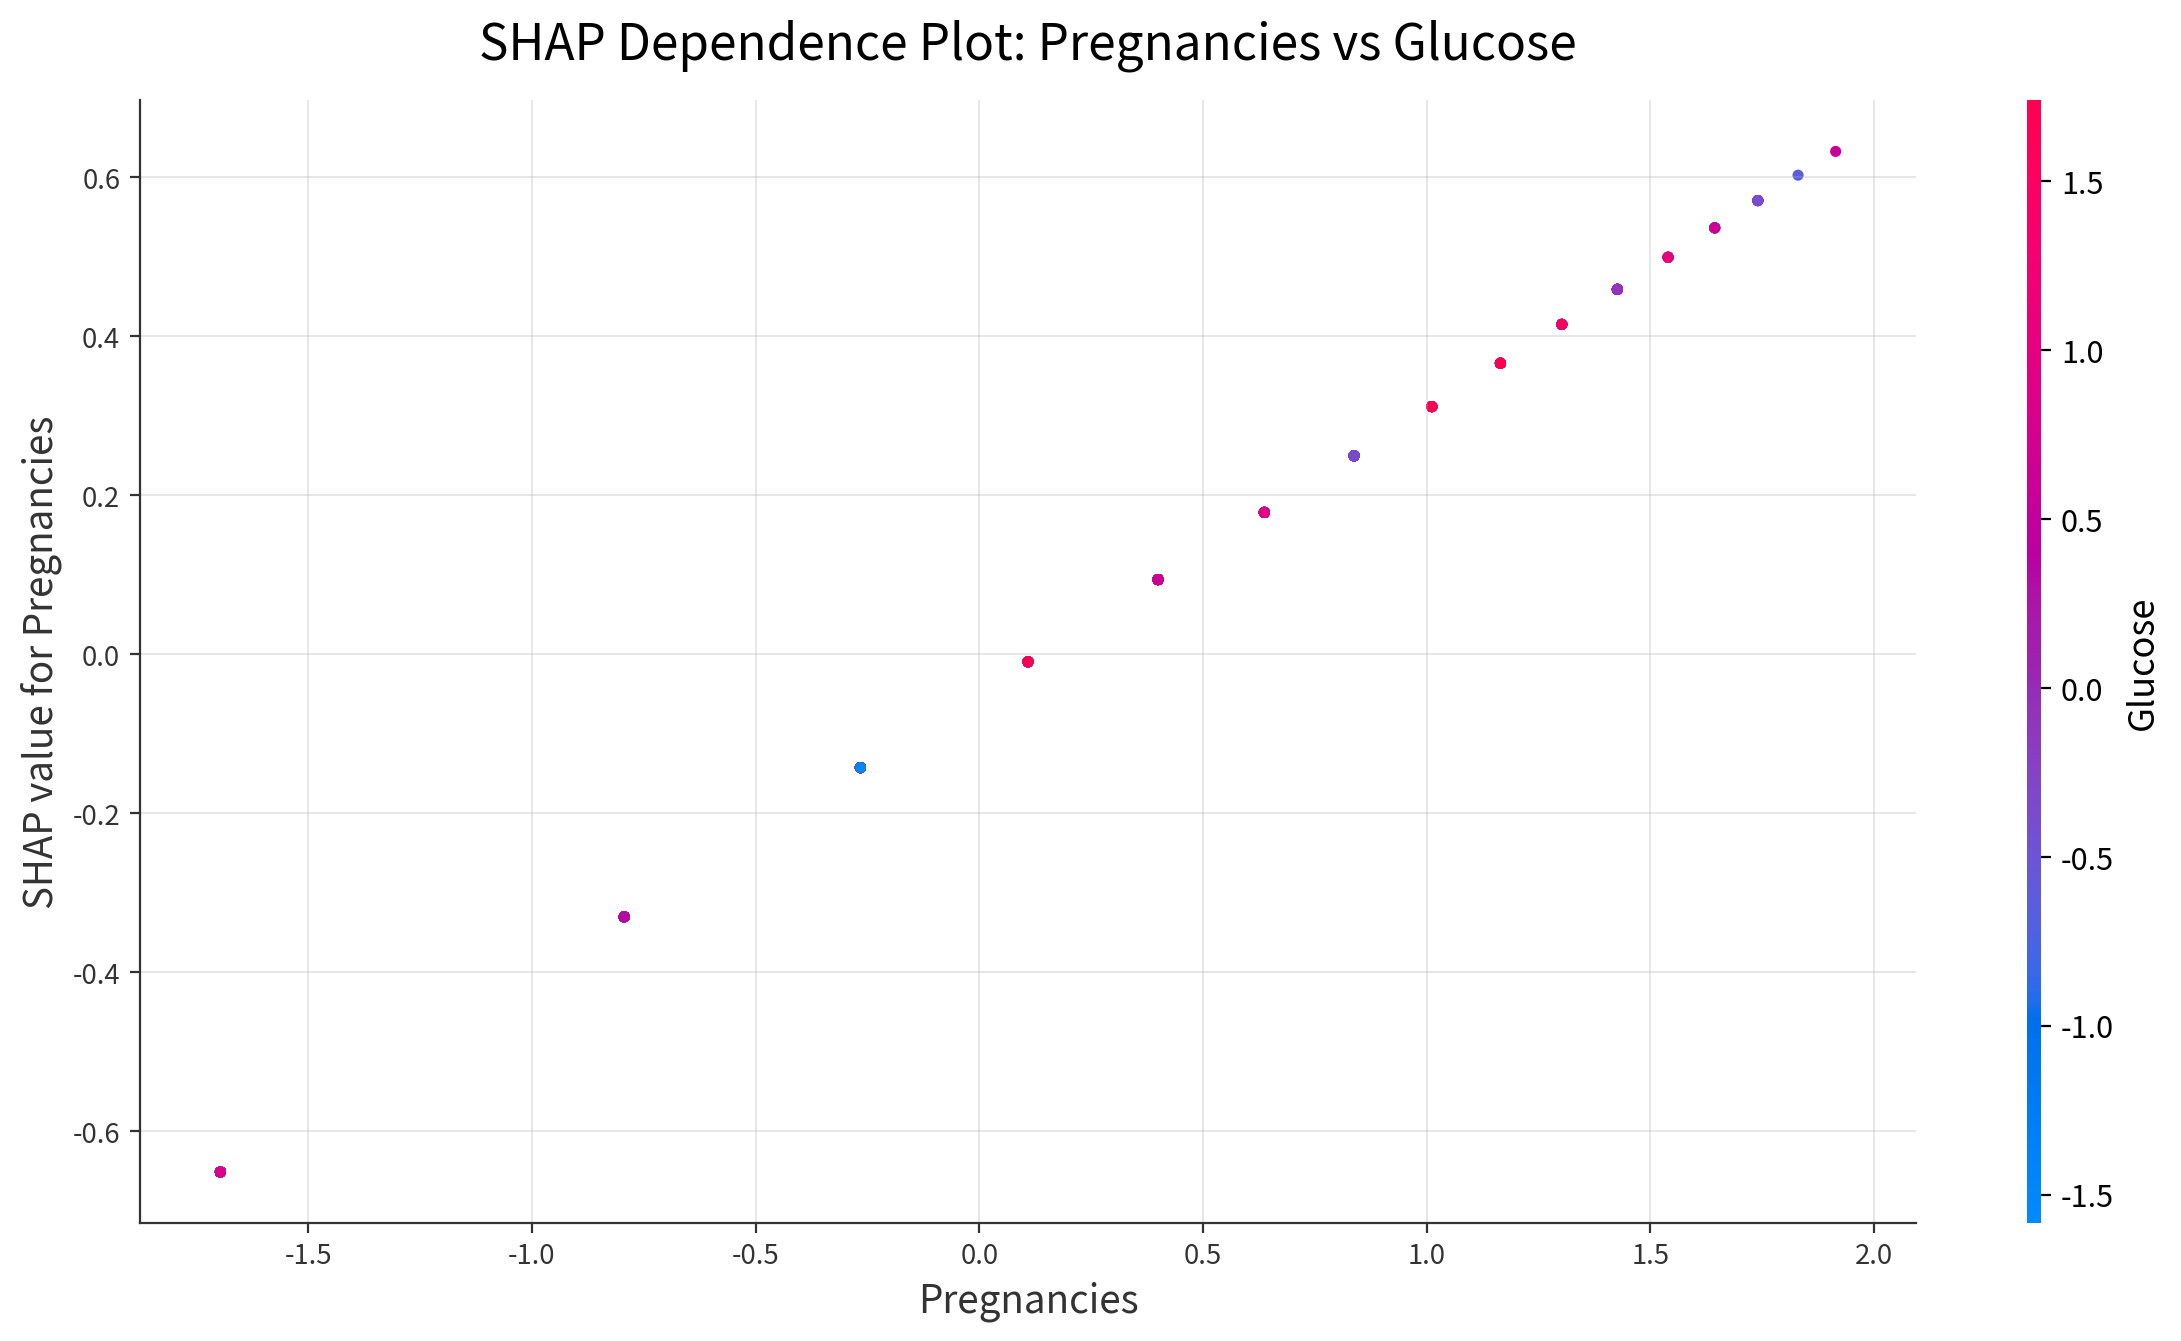

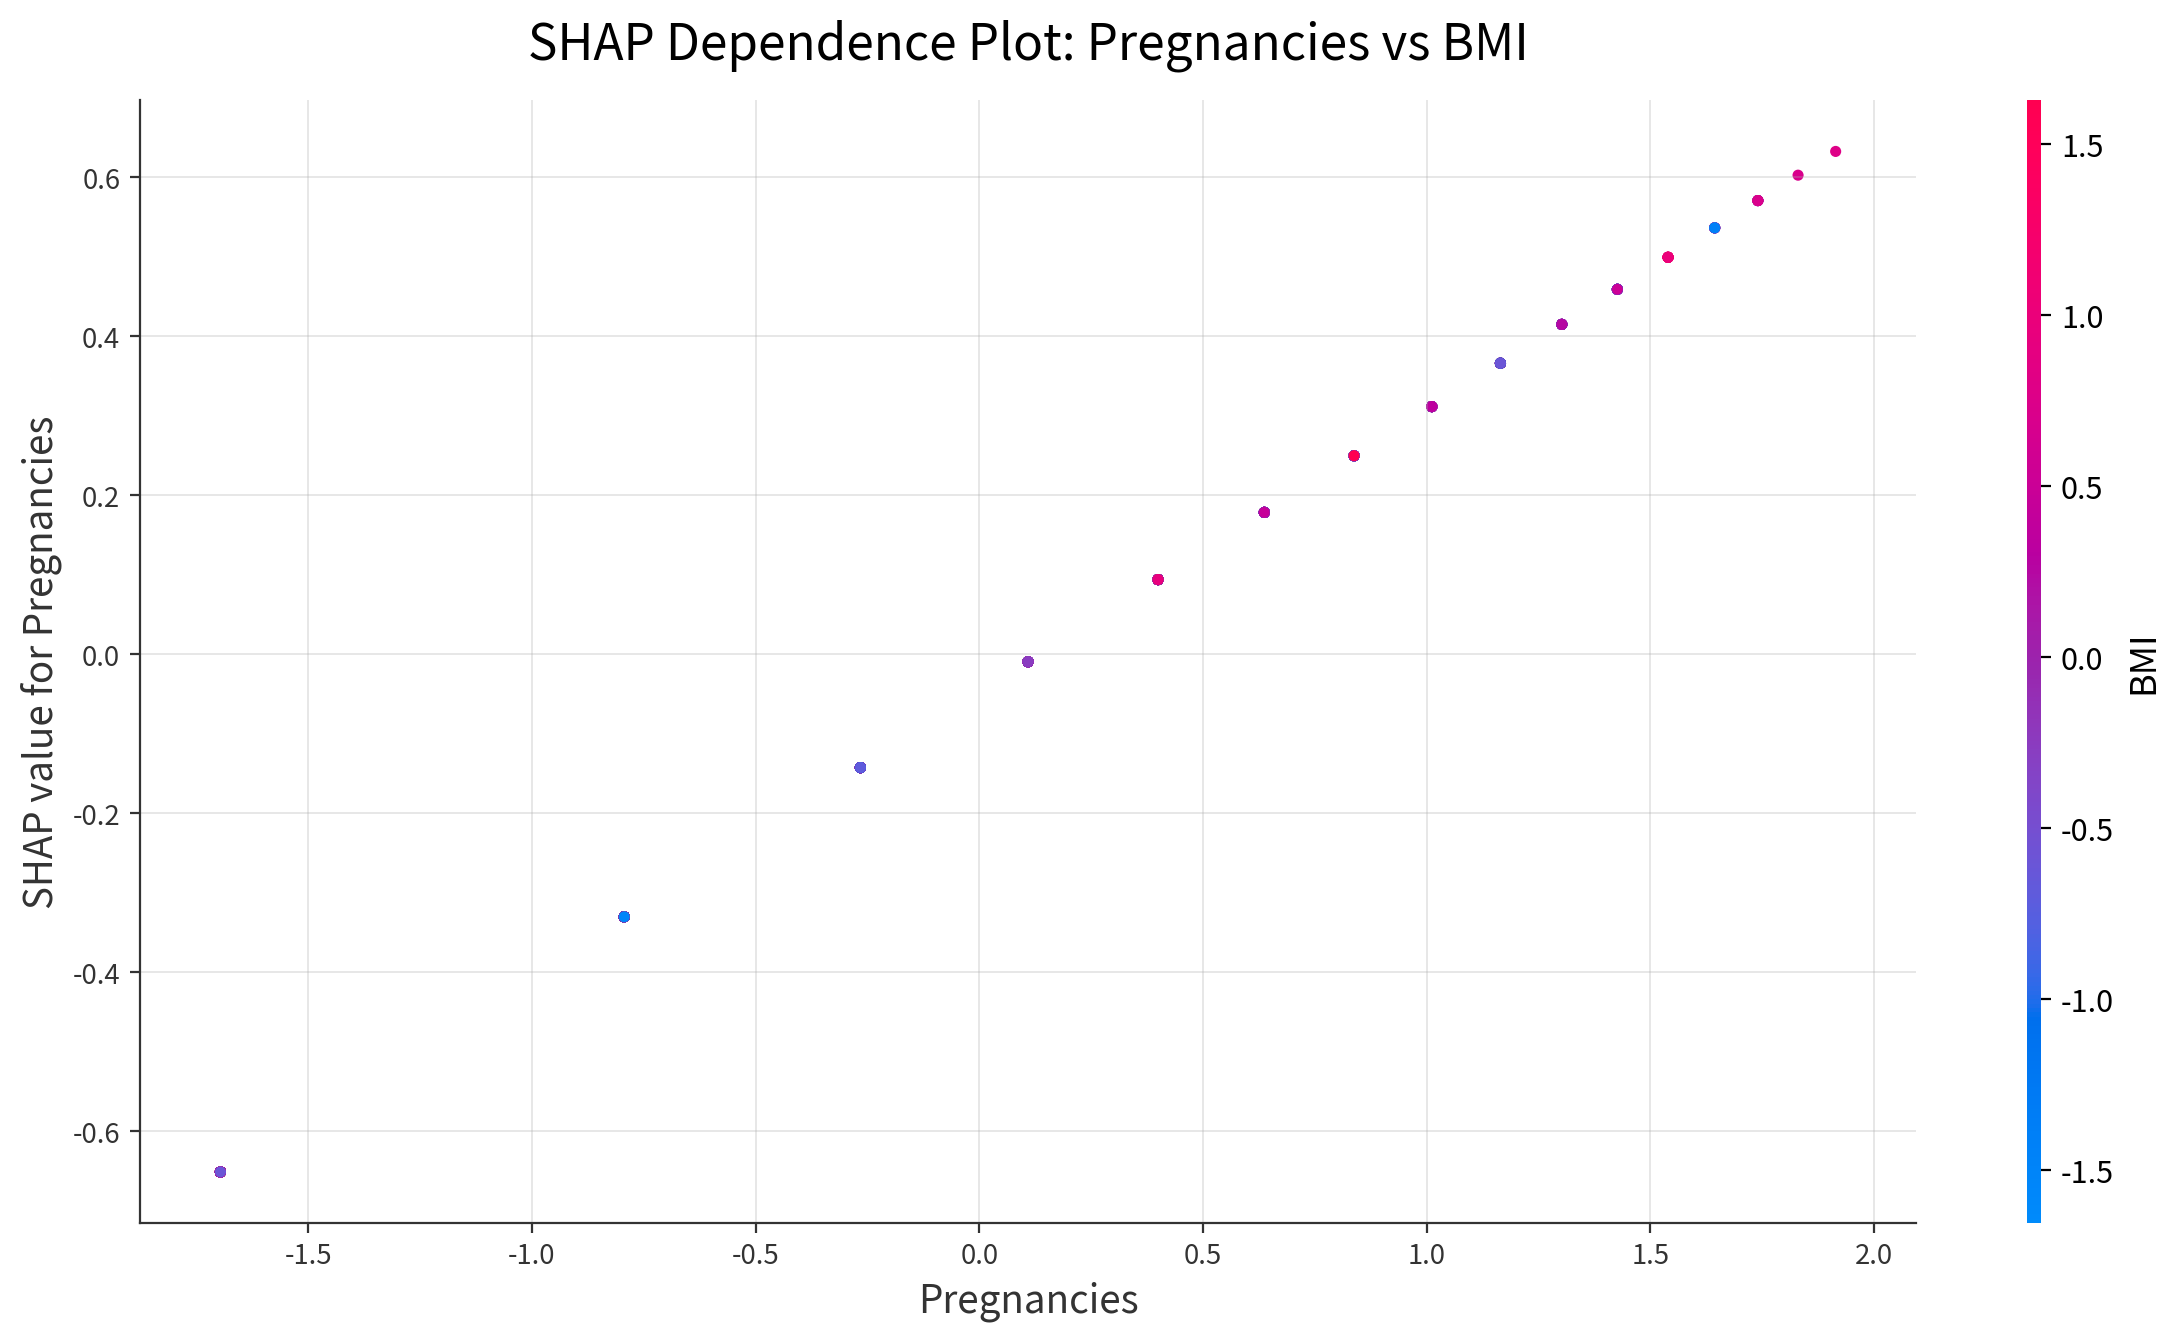

[('BMI', 'Glucose'), ('Pregnancies', 'Glucose'), ('Pregnancies', 'BMI')]

In [15]:
hs_shap_dependence_analysis(summary_df, shap_values, DataFrame(x_scaled, columns = x.columns))